# Reddit Example Dataset

## A walkthrough of the dataset code for the Big Graph Dataset project

Alex Davies, University of Bristol, 2024

In this notebook we'll write code to:

- download a large Reddit graph from an online repository
- sample that graph to produce a dataset of smaller graphs
- process that dataset into a Pytorch Geometric InMemoryDataset

---

### Getting the graph

First we need to download the graph, here from the  [Stanford Network Analysis Project](http://snap.stanford.edu/data/soc-RedditHyperlinks.html)

We first find the links for the graph and node features (here node features are text embeddings):

In [1]:
graph_url = "https://snap.stanford.edu/data/soc-redditHyperlinks-title.tsv"
embedding_url = "http://snap.stanford.edu/data/web-redditEmbeddings-subreddits.csv"

Then play with directories and download the data:

In [2]:
import os
import pickle
import wget
import pandas as pd

# Swap into dataset directory
print(os.getcwd())
start_dir = os.getcwd()
os.chdir("bgd_files")

# We won't actually need this part in the final function!
if "reddit" not in os.listdir():
    os.mkdir("reddit")
    
os.chdir("reddit")

#  Download raw files if we don't already have them
if "soc-redditHyperlinks-title.tsv" not in os.listdir():
    graph_data = wget.download(graph_url) # Edgelist and edge features
if "web-redditEmbeddings-subreddits.csv" not in os.listdir():
    embedding_data = wget.download(embedding_url) # Node features

# We know that there are 300 components in the node feature vectors
embedding_column_names = ["COMPONENT", *[i for i in range(300)]]
embeddings = pd.read_csv("web-redditEmbeddings-subreddits.csv", names=embedding_column_names).transpose()
graph_data = pd.read_csv("soc-redditHyperlinks-title.tsv", sep = "\t")


# Avoids weird directory problems
os.chdir(start_dir)



/home/alex/Projects/big-graph-dataset


Let's have a look at the node embeddings:

In [3]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,51268,51269,51270,51271,51272,51273,51274,51275,51276,51277
COMPONENT,spiders,askreddit,globaloffensivetrade,fireteams,funny,the_donald,videos,news,leagueoflegends,rocketleagueexchange,...,motleyfool,govtjobsrchinindia,snoopdogg,fortean,whatcanidoforbernie,33rd,bestofvic2015,aberystwyth,mail_forwarding,cover
0,0.158972,-0.499114,-0.023145,2.492506,-0.81937,-0.123265,0.131896,0.132825,-2.785298,0.553341,...,0.004494,0.001908,-0.000534,0.000615,0.000906,-0.000076,-0.000203,-0.001563,0.009269,0.00457
1,0.285813,0.323983,-1.199374,-2.529917,-0.865261,-0.610208,0.866419,1.505527,-0.166391,-3.283354,...,0.052268,0.042618,0.023619,0.023847,0.017816,-0.001643,0.012698,0.004733,0.024779,0.012403
2,0.226329,-0.424809,1.661484,-0.448484,0.301753,0.361495,0.919025,0.730393,1.592624,-3.091485,...,-0.027792,-0.021329,-0.003317,-0.018297,-0.004231,-0.002896,-0.007575,-0.000082,-0.017018,-0.000363
3,-0.183338,-0.222705,-1.025296,-3.543441,0.018787,-1.171773,-0.765584,-0.505759,-1.269829,0.877085,...,0.013468,0.012,0.005566,-0.004873,-0.010438,0.000581,0.006486,-0.000982,-0.007228,-0.002496


And now the edges:

In [4]:
graph_data.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,rddtgaming,rddtrust,1u4pzzs,2013-12-31 16:39:18,1,"25.0,23.0,0.76,0.0,0.44,0.12,0.12,4.0,4.0,0.0,..."
1,xboxone,battlefield_4,1u4tmfs,2013-12-31 17:59:11,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
2,ps4,battlefield_4,1u4tmos,2013-12-31 17:59:40,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
3,fitnesscirclejerk,leangains,1u50xfs,2013-12-31 19:01:56,1,"49.0,43.0,0.775510204082,0.0,0.265306122449,0...."
4,fitnesscirclejerk,lifeprotips,1u51nps,2013-12-31 21:02:28,1,"14.0,14.0,0.785714285714,0.0,0.428571428571,0...."


---

### Turn the data into a graph

Now we need to turn the data into a graph. 
Our edges come from graph_data (SOURCE and TARGET), including categories for each edge (LINK_SENTIMENT), as well as edge features (PROPERTIES). 

The first step is making a networkx.Graph object, which is a useful graph class, then we add the nodes one by one. 
We'll include the text embedding for the subreddit as a node attribute, taken from the embedding dataframe.

In [5]:
# networkx is a Python library for graph structures
import networkx as nx
# tqdm for loading bars
from tqdm import tqdm
# cheeky function to visualise a networkx graph
from utils import vis_networkx

embeddings.columns = embeddings.iloc[0]
embeddings = embeddings.drop(["COMPONENT"], axis = 0)

graph = nx.Graph()

# Add a node for each id in the embedding data
for col in tqdm(embeddings.columns, desc = "Adding nodes"):
    # attrs here is taken from the embedding data, with the node id the column (col)
    graph.add_node(col, attrs=embeddings[col].to_numpy().astype(float))

Adding nodes: 100%|██████████| 51278/51278 [00:01<00:00, 32961.66it/s]


Now we add the edges (the actual graph stuff).

We need to include two properties:

- Type of edge, negative or positive interaction, -1 or 1. In dataframe as LINK_SENTIMENT
- Properties of the edge, text embedding of the reddit post content 


In [6]:
import numpy as np

def fix_property_string(input_string):
    input_string = input_string.split(',')
    input_string = [float(item) for item in input_string]

    return np.array(input_string)

sources = graph_data["SOURCE_SUBREDDIT"].to_numpy()
targets = graph_data["TARGET_SUBREDDIT"].to_numpy()

# This line can take a while!
attrs = [fix_property_string(properties) for properties in tqdm(graph_data["PROPERTIES"].tolist(), desc = "Wrangling edge features")]

Wrangling edge features: 100%|██████████| 571927/571927 [00:05<00:00, 103705.47it/s]


Now iterate over the edges, only adding them if their nodes have data:

In [7]:

labels = graph_data["LINK_SENTIMENT"].to_numpy()
all_nodes = list(graph.nodes())

for i in tqdm(range(sources.shape[0]), desc = "Adding edges"):
    # Check that the edge has data
    if sources[i] in all_nodes and targets[i] in all_nodes:
        graph.add_edge(sources[i], targets[i],
                    labels = labels[i],
                    attr = attrs[i])

Adding edges: 100%|██████████| 571927/571927 [00:37<00:00, 15434.45it/s]


In [8]:
print(graph)

# Last tidying bits
graph = nx.convert_node_labels_to_integers(graph)
CGs = [graph.subgraph(c) for c in nx.connected_components(graph)]
CGs = sorted(CGs, key=lambda x: x.number_of_nodes(), reverse=True)
graph = CGs[0]
graph = nx.convert_node_labels_to_integers(graph)

# Save the graph!
with open("bgd_files/reddit/reddit-graph.npz", "wb") as f:
    pickle.dump(graph, f)

Graph with 51278 nodes and 178143 edges


Nice! Graph achieved. Spot that in the last section we had to deal with some missing data - we're including edges ONLY if their nodes also have data.

---

## Sample to make a dataset of smaller graphs

This is not too hard, I've written some code (Exploration Sampling With Replacement, ESWR) that does the sampling for you.

This will produce a big list of small networkx graphs sampled from that original graph.

In [9]:
from utils import ESWR

# Sample 1000 graphs of max 96 nodes from the big reddit graph
nx_graph_list = ESWR(graph, 1000, 96)


Sampling 1000 in 5 chunks with size 200


Sampling from large graph: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]

Done sampling!



Next we need to convert it to a Pytorch Geometric format.
This will be specific to your data - here we have node labels, edge labels, edge attributes.

In [10]:
import torch
from torch_geometric.data import Data

def specific_from_networkx(graph):
    # Turns a graph into a pytorch geometric object
    # Mostly by unpacking dictionaries on nodes and edges
    # Here node labels are the target
    # One of these functions for each dataset ideally - they are unlikely to transfer across datasets
    node_attrs = []
    edge_indices = []
    edge_labels = []
    edge_attrs = []

    # Collect node labels and attributes
    for n in list(graph.nodes(data=True)):
        # list(graph.nodes(data=True)) returns [(node_id1, {attribute dictionary}), (node_id2, ...), (node_id3, ...)]
        node_attrs.append(torch.Tensor(n[1]["attrs"]))

    # Collect edge indices and attributes
    for e in graph.edges(data=True):
        # graph.edges(data=True) is a generator producing (node_id1, node_id2, {attribute dictionary})
        edge_indices.append((e[0], e[1]))

        edge_attrs.append(torch.Tensor(e[2]["attr"])) 
        edge_labels.append(e[2]["labels"])


    # Specific to classification on edges! This is a binary edge classification (pos/neg) task
    edge_labels = ((torch.Tensor(edge_labels) + 1)/2).reshape(-1,1)

    edge_attrs = torch.stack(edge_attrs)
    node_attrs = torch.stack(node_attrs)
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    # Create PyG Data object
    # Can pass:
    # x:            node features, shape (n nodes x n features)
    # edge_index:   the list of edges in the graph, shape (2, n_edges). Entries edge_index[i, :] are [node_id1, node_id2].
    # edge_attr:    edge features, shape (n_edges, n_features), same order as edgelist
    # y:            targets. Graph regression shape (n_variables), graph classification (n_classes), node classification (n_nodes, n_classes), edge classification (n_edges, n_classes)
    data = Data(x=node_attrs, edge_index=edge_indices, edge_attr = edge_attrs,  y=edge_labels)

    return data

print("Data in torch geometric format:")
specific_from_networkx(nx_graph_list[0])

Data in torch geometric format:


/home/alex/anaconda3/envs/adgcl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(x=[54, 300], edge_index=[2, 249], edge_attr=[249, 86], y=[249, 1])

---

## The final dataset

Finally we place all that data into an InMemoryDataset!

Please note that in-code this whole notebook will be in functions - see `datasets/example_dataset.py`.

This means that the `datalist` argument wouldn't actually exist below - instead you'd call something like `get_reddit_dataset()` within your `.process` method.

Converting data to PyG data objects: 100%|██████████| 1000/1000 [00:01<00:00, 991.15it/s]
/home/alex/Projects/big-graph-dataset/utils.py:398: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


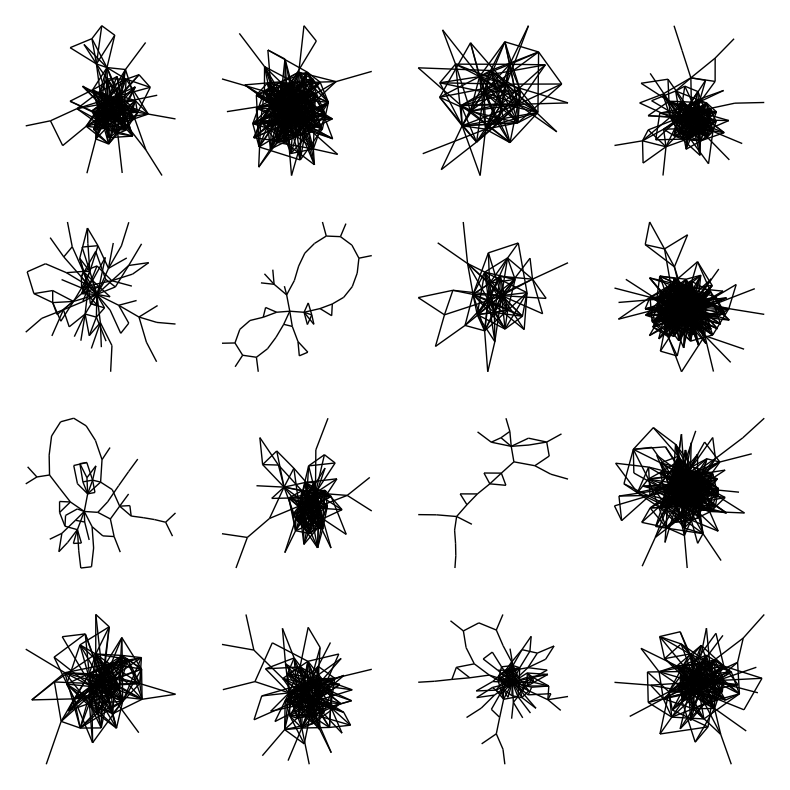

Cora files exist


Processing...
Done!


In [13]:
from torch_geometric.data import InMemoryDataset
from utils import vis_grid

class RedditDataset(InMemoryDataset):
    r"""
    Reddit hyperlink graphs - ie graphs of subreddits interacting with one another.
    The original graph is sourced from:

    `Kumar, Srijan, et al. "Community interaction and conflict on the web." Proceedings of the 2018 world wide web conference. 2018.`

    The data has text embeddings as node features for each subreddit and text features for the cross-post edges.

    The task is edge classification for the sentiment of the interaction between subreddits.

    - Task: Edge classification
    - Num node features: 300
    - Num edge features: 86
    - Num target values: 1
    - Target shape: N Edges
    - Num graphs: Parameterised by `num`

    Args:
    root (str): Root directory where the dataset should be saved.
    datalist (list): A list of pytorch geometric data objects. Only obtained from an argument here, not in actual code!
    stage (str): The stage of the dataset to load. One of "train", "val", "test". (default: :obj:`"train"`)
    transform (callable, optional): A function/transform that takes in an :obj:`torch_geometric.data.Data` object and returns a transformed version. The data object will be transformed before every access. (default: :obj:`None`)
    pre_transform (callable, optional): A function/transform that takes in an :obj:`torch_geometric.data.Data` object and returns a transformed version. The data object will be transformed before being saved to disk. (default: :obj:`None`)
    pre_filter (callable, optional): A function that takes in an :obj:`torch_geometric.data.Data` object and returns a boolean value, indicating whether the data object should be included in the final dataset. (default: :obj:`None`)
    num (int): The number of samples to take from the original dataset. (default: :obj:`2000`).
    """

    # datalist is only an argument for this notebook example - see existing datasets under datasets/.. for how it actually works
    def __init__(self, root, datalist, stage = "train", transform=None, pre_transform=None, pre_filter=None, num = 2000):
        self.num = num
        self.stage = stage
        self.stage_to_index = {"train":0,
                               "val":1,
                               "test":2}
        self.datalist = datalist

        # Options are node-classification, node-regression, graph-classification, graph-regression, edge-regression, edge-classification
        # Graph-level tasks are preferred! (graph-classification and graph-regression)
        # edge-prediction is another option if you can't think of a good task
        self.task = "node-classification"

        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[self.stage_to_index[self.stage]])


    @property
    def raw_file_names(self):
        # Replace with your saved raw file name
        return ['reddit-graph.npz']

    @property
    def processed_file_names(self):
        return ['train.pt',
                'val.pt',
                'test.pt']


    def process(self):
        # Read data into huge `Data` list.

        if os.path.isfile(self.processed_paths[self.stage_to_index[self.stage]]):
            print(f"Cora files exist")
            return

        # Get a list of num pytorch_geometric.data.Data objects
        data_list = self.datalist # get_example_dataset(num=self.num)

        # Torch geometric stuff
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        # Save data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[self.stage_to_index[self.stage]])

pyg_graphs = [specific_from_networkx(g) for g in tqdm(nx_graph_list, desc = "Converting data to PyG data objects")]

# The visualisation doesn't work in documentation :( uncomment to see the graphs
vis_grid(pyg_graphs[:16], os.getcwd() + "/bgd_files/reddit/example.png", show_plot = True)

train_dataset = RedditDataset(os.getcwd() + "/bgd_files/reddit",
                              pyg_graphs)

## Other datsets

There are already some datasets we can look at under datasets/DATASET.py.

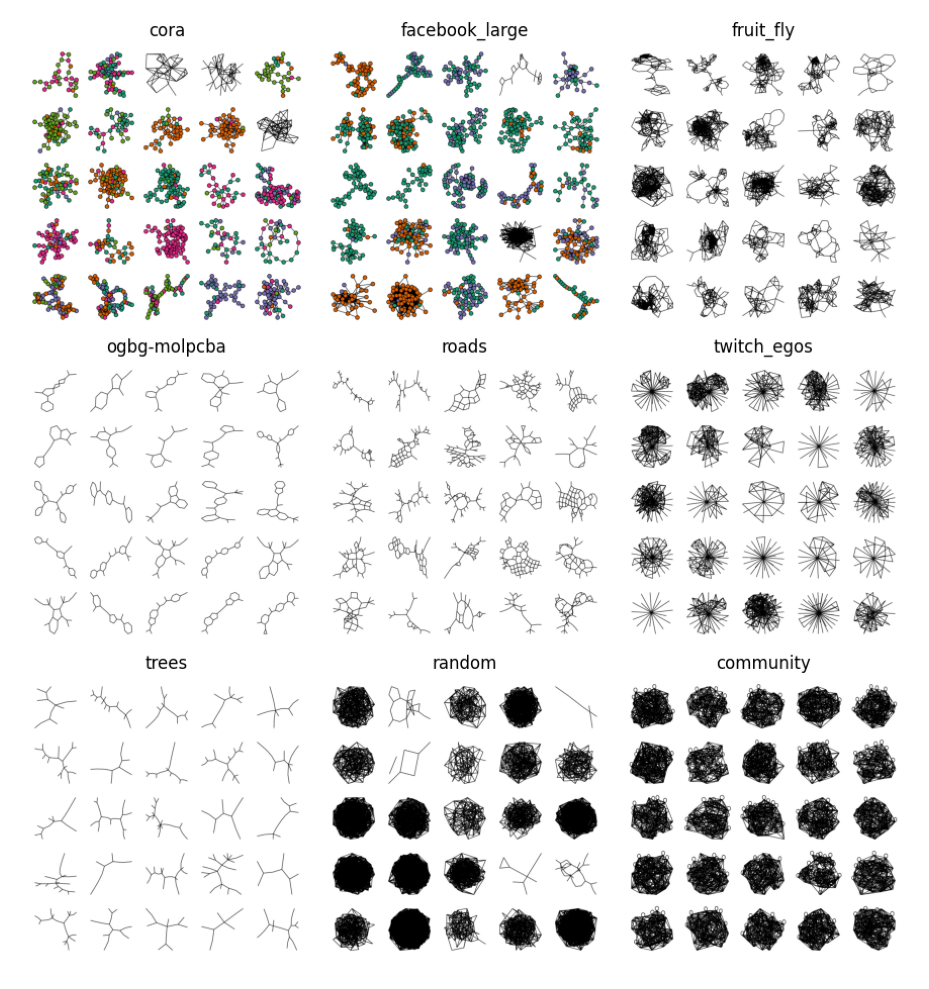

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
im = plt.imread("docs/source/_static/datasets.png")
plt.imshow(im)
plt.axis('off')
plt.tight_layout()
plt.show()